In the dataset, Y_labels are represented as numbers from 1 to 6 as their identifiers.
WALKING as 1
WALKING_UPSTAIRS as 2
WALKING_DOWNSTAIRS as 3
SITTING as 4
STANDING as 5
LAYING as 6

in Data exploration section we observed that we can divide the data into dynamic and static type so devided walking,waling_upstairs,walking_downstairs into category 0 i.e Dynamic, sitting, standing, laying into category 1 i.e. static.
Will use 2 more classifiers seperatly for classifying classes of dynamic and static activities. so that model can learn differnt features for static and dynamic activities

# Importing libraries and packages

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0) 
# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from tensorflow.compat.v1.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(0) 

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
# Importing libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#Loading training and test dataset

In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
## Classifying data as 2 class dynamic vs static 
##data preparation
def data_scaled_2class():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    import pickle
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            ##saving for furter usage
            ## will use in predicton pipeline
            pickle.dump(scale,open('Scale_2class.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).to_numpy()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        """
        filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y[y<=3] = 0
        y[y>3] = 1
        return pd.get_dummies(y).to_numpy()
    
    X_train_2c, X_val_2c = load_signals('train'), load_signals('test')
    Y_train_2c, Y_val_2c = load_y('train'), load_y('test')
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_2c)
    X_train_2c = Scale.transform(X_train_2c)
    X_val_2c = Scale.transform(X_val_2c)
    return X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c

In [7]:
X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c = data_scaled_2class()

In [8]:
print(Y_train_2c.shape)
print(Y_val_2c.shape)

(7352, 2)
(2947, 2)


# Model for classifying data into Static and Dynamic activities

In [9]:
K.clear_session()
np.random.seed(0)
tf.random.set_seed(0) 
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 32)           896       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout (Dropout)            (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                99250     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [11]:
import math
import keras
adam = keras.optimizers.Adam(lr=0.001)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_2c,Y_train_2c, epochs=20, batch_size=16,validation_data=(X_val_2c, Y_val_2c), verbose=1)

Epoch 1/20
460/460 [==============================] - 3s 7ms/step - loss: 0.0425 - accuracy: 0.9860 - val_loss: 0.2569 - val_accuracy: 0.9664
Epoch 2/20
460/460 [==============================] - 3s 7ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0074 - val_accuracy: 0.9990
Epoch 3/20
460/460 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0179 - val_accuracy: 0.9932
Epoch 4/20
460/460 [==============================] - 3s 7ms/step - loss: 3.3991e-05 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9929
Epoch 5/20
460/460 [==============================] - 3s 7ms/step - loss: 5.5422e-05 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9929
Epoch 6/20
460/460 [==============================] - 3s 7ms/step - loss: 2.1158e-05 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9932
Epoch 7/20
460/460 [==============================] - 3s 7ms/step - loss: 5.2984e-06 - accuracy: 1.0000 - val_loss: 0.0170 - val_accurac

In [13]:
_,acc_val = model.evaluate(X_val_2c,Y_val_2c,verbose=0)
_,acc_train = model.evaluate(X_train_2c,Y_train_2c,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9874448776245117


In [14]:
##saving model
model.save('final_model_2class.h5')

**This model is almost classifying data into dynammic or static correctly with very hig accuracy***

#Classificaton of Static activities¶


In [17]:
##data preparation
def data_scaled_static():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    import pickle
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            #for furter use at prediction pipeline
            pickle.dump(scale,open('Scale_static.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).to_numpy()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
  
        """
        filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y>3
        y = y[y_subset]
        return pd.get_dummies(y).to_numpy(),y_subset
    
    Y_train_s,y_train_sub = load_y('train')
    Y_val_s,y_test_sub = load_y('test')
    X_train_s, X_val_s = load_signals('train'), load_signals('test')
    X_train_s = X_train_s[y_train_sub]
    X_val_s = X_val_s[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_s)
    X_train_s = Scale.transform(X_train_s)
    X_val_s = Scale.transform(X_val_s)

    return X_train_s, Y_train_s, X_val_s,  Y_val_s


In [18]:
X_train_s, Y_train_s, X_val_s,  Y_val_s = data_scaled_static()

In [19]:
print('X Shape of train data',X_train_s.shape, 'Y shape', Y_train_s.shape)
print('X Shape of val data',X_val_s.shape,'Y shape',Y_val_s.shape)


X Shape of train data (4067, 128, 9) Y shape (4067, 3)
X Shape of val data (1560, 128, 9) Y shape (1560, 3)


#Baseline Model

In [57]:
np.random.seed(0)
tf.random.set_seed(0) 
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 122, 64)           4096      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                38430     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [58]:
import math
import keras
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=20, batch_size=32,validation_data=(X_val_s, Y_val_s), verbose=1)
K.clear_session()


Epoch 1/20
128/128 [==============================] - 2s 16ms/step - loss: 0.3491 - accuracy: 0.8790 - val_loss: 0.3339 - val_accuracy: 0.8910
Epoch 2/20
128/128 [==============================] - 2s 15ms/step - loss: 0.2449 - accuracy: 0.9014 - val_loss: 0.3061 - val_accuracy: 0.8551
Epoch 3/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1823 - accuracy: 0.9275 - val_loss: 0.2669 - val_accuracy: 0.9199
Epoch 4/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1918 - accuracy: 0.9257 - val_loss: 0.2690 - val_accuracy: 0.9019
Epoch 5/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1952 - accuracy: 0.9334 - val_loss: 0.2495 - val_accuracy: 0.9160
Epoch 6/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1356 - accuracy: 0.9459 - val_loss: 0.2327 - val_accuracy: 0.8987
Epoch 7/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1291 - accuracy: 0.9501 - val_loss: 0.2007 - val_accuracy: 0.9186

In [60]:
_,acc_val = model.evaluate(X_val_s,Y_val_s,verbose=0)
_,acc_train =model.evaluate(X_train_s,Y_train_s,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9761494994163513 test_accuracy 0.9435897469520569


In [61]:
# Confusion Matrix
# Activities are the class labels
# It is a 3 class classification
from sklearn import metrics
ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

# Confusion Matrix
print(confusion_matrix_cnn(Y_val_s,model.predict(X_val_s)))

[[537   0   0]
 [  3 419  69]
 [  0  16 516]]


In [62]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

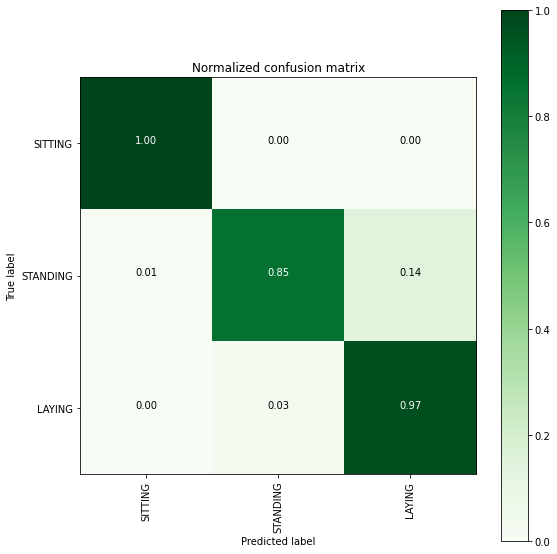

In [63]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_s, model.predict(X_val_s))
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

In [65]:
##saving model
model.save('final_model_static.h5')

# Classification of Dynamic activities 

In [68]:
##data preparation
def data_scaled_dynamic():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    import pickle
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            pickle.dump(scale,open('Scale_dynamic.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).to_numpy()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y<=3
        y = y[y_subset]
        return pd.get_dummies(y).to_numpy(),y_subset
    
    Y_train_d,y_train_sub = load_y('train')
    Y_val_d,y_test_sub = load_y('test')
    X_train_d, X_val_d = load_signals('train'), load_signals('test')
    X_train_d = X_train_d[y_train_sub]
    X_val_d = X_val_d[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_d)
    X_train_d = Scale.transform(X_train_d)
    X_val_d = Scale.transform(X_val_d)

    return X_train_d, Y_train_d, X_val_d,  Y_val_d

In [69]:
X_train_d, Y_train_d, X_val_d,  Y_val_d = data_scaled_dynamic()

In [70]:
print('Train X shape',X_train_d.shape,'Test X shape',X_val_d.shape)
print('Train Y shape',Y_train_d.shape,'Test Y shape',Y_val_d.shape)

Train X shape (3285, 128, 9) Test X shape (1387, 128, 9)
Train Y shape (3285, 3) Test Y shape (1387, 3)


#Baseline Model

In [71]:
np.random.seed(0)
tf.random.set_seed(0) 
sess =tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 122, 64)           4096      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                38430     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [72]:
import math
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=60, batch_size=16,validation_data=(X_val_s, Y_val_s), verbose=1)
K.clear_session()

Epoch 1/60
255/255 [==============================] - 2s 10ms/step - loss: 0.4181 - accuracy: 0.8699 - val_loss: 0.3208 - val_accuracy: 0.8872
Epoch 2/60
255/255 [==============================] - 2s 9ms/step - loss: 0.2080 - accuracy: 0.9174 - val_loss: 0.2740 - val_accuracy: 0.8955
Epoch 3/60
255/255 [==============================] - 2s 9ms/step - loss: 0.2092 - accuracy: 0.9238 - val_loss: 0.2593 - val_accuracy: 0.8974
Epoch 4/60
255/255 [==============================] - 2s 9ms/step - loss: 0.1695 - accuracy: 0.9378 - val_loss: 0.2251 - val_accuracy: 0.9179
Epoch 5/60
255/255 [==============================] - 2s 9ms/step - loss: 0.1406 - accuracy: 0.9449 - val_loss: 0.2129 - val_accuracy: 0.9321
Epoch 6/60
255/255 [==============================] - 2s 9ms/step - loss: 0.1246 - accuracy: 0.9548 - val_loss: 0.2178 - val_accuracy: 0.9237
Epoch 7/60
255/255 [==============================] - 2s 9ms/step - loss: 0.2385 - accuracy: 0.9304 - val_loss: 0.2992 - val_accuracy: 0.8949
Epoch

In [73]:
from tensorflow.python.keras import regularizers
np.random.seed(0)
tf.random.set_seed(0) 
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)
# Initiliazing the sequential model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=7,activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=regularizers.l2(0.5485959479177),input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=7, 
                activation='relu',kernel_regularizer=regularizers.l2(0.28312064960787),kernel_initializer='he_uniform'))
model.add(Dropout(0.6725241946))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(lr=0.000832635847)
rmsprop = keras.optimizers.RMSprop(lr=0.002098660517)
choiceval = 'adam'
if choiceval == 'adam':
        optim = adam
else:
        optim = rmsprop
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 122, 32)           2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 32)           7200      
_________________________________________________________________
dropout (Dropout)            (None, 116, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 736)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                47168     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [76]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)

In [77]:
result = model.fit(X_train_d, Y_train_d,
                    batch_size=32,
                    epochs=19,
                    verbose=1,
                    validation_data=(X_val_d, Y_val_d))

Epoch 1/19
103/103 [==============================] - 2s 20ms/step - loss: 35.3636 - accuracy: 0.6843 - val_loss: 20.3597 - val_accuracy: 0.8399
Epoch 2/19
103/103 [==============================] - 2s 15ms/step - loss: 12.4913 - accuracy: 0.9379 - val_loss: 7.2687 - val_accuracy: 0.9430
Epoch 3/19
103/103 [==============================] - 2s 15ms/step - loss: 4.3374 - accuracy: 0.9756 - val_loss: 2.7596 - val_accuracy: 0.8688
Epoch 4/19
103/103 [==============================] - 2s 15ms/step - loss: 1.5371 - accuracy: 0.9842 - val_loss: 1.1878 - val_accuracy: 0.9539
Epoch 5/19
103/103 [==============================] - 2s 15ms/step - loss: 0.6157 - accuracy: 0.9842 - val_loss: 0.6594 - val_accuracy: 0.9625
Epoch 6/19
103/103 [==============================] - 2s 15ms/step - loss: 0.2975 - accuracy: 0.9924 - val_loss: 0.4936 - val_accuracy: 0.9596
Epoch 7/19
103/103 [==============================] - 2s 15ms/step - loss: 0.2018 - accuracy: 0.9936 - val_loss: 0.4211 - val_accuracy: 0.9

In [78]:
_,acc_val = model.evaluate(X_val_d,Y_val_d,verbose=0)
_,acc_train = model.evaluate(X_train_d,Y_train_d,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9783706068992615


In [80]:
from sklearn import metrics
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
}

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

# Confusion Matrix
print(confusion_matrix_cnn(Y_val_d,model.predict(X_val_d)))

[[494   1   1]
 [  1 417   2]
 [  1  24 446]]


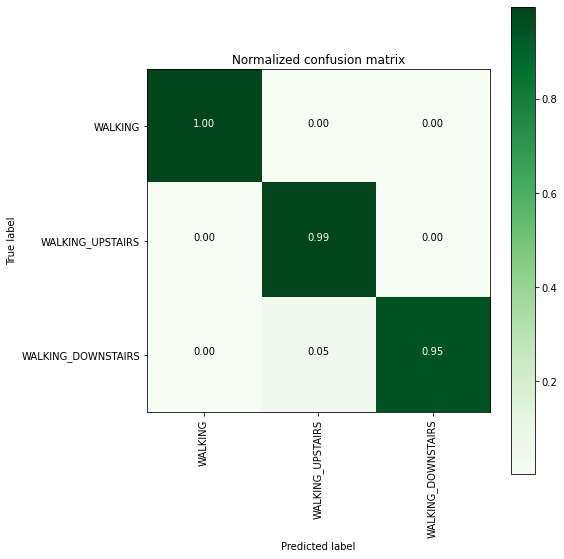

In [82]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_d,model.predict(X_val_d))
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

In [84]:
#saving model
model.save('final_model_dynamic.h5')

In [87]:
def data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).to_numpy()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        """
        filename = f'/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        return y
    
    X_train, X_val = load_signals('train'), load_signals('test')
    Y_train, Y_val = load_y('train'), load_y('test')

    return X_train, Y_train, X_val,  Y_val

In [88]:
X_train, Y_train, X_val,  Y_val = data()

In [89]:
print('shape of test Y',Y_val.shape)

shape of test Y (2947,)


#Final prediction pipeline

In [90]:
##loading keras models and picle files for scaling data 
from keras.models import load_model
import pickle
model_2class = load_model('final_model_2class.h5')
model_dynamic = load_model('final_model_dynamic.h5')
model_static = load_model('final_model_static.h5')
scale_2class = pickle.load(open('Scale_2class.p','rb'))
scale_static = pickle.load(open('Scale_static.p','rb'))
scale_dynamic = pickle.load(open('Scale_dynamic.p','rb'))

In [91]:
##scaling the data
def transform_data(X,scale):
    X_temp = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    X_temp = scale.transform(X_temp)
    return X_temp.reshape(X.shape)

In [92]:
#predicting output activity
def predict_activity(X):
    ##predicting whether dynamic or static
    predict_2class = model_2class.predict(transform_data(X,scale_2class))
    Y_pred_2class =  np.argmax(predict_2class, axis=1)
    #static data filter
    X_static = X[Y_pred_2class==1]
    #dynamic data filter
    X_dynamic = X[Y_pred_2class==0]
    #predicting static activities
    predict_static = model_static.predict(transform_data(X_static,scale_static))
    predict_static = np.argmax(predict_static,axis=1)
    #adding 4 because need to get inal prediction lable as output
    predict_static = predict_static + 4
    #predicting dynamic activites
    predict_dynamic = model_dynamic.predict(transform_data(X_dynamic,scale_dynamic))
    predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    predict_dynamic = predict_dynamic + 1
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_pred = []
    for mask in Y_pred_2class:
        if mask == 1:
            final_pred.append(predict_static[i])
            i = i + 1
        else:
            final_pred.append(predict_dynamic[j])
            j = j + 1 
    return final_pred

In [93]:
##predicting 
final_pred_val = predict_activity(X_val)
final_pred_train = predict_activity(X_train)

In [94]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(Y_train,final_pred_train))
print('Accuracy of validation data',accuracy_score(Y_val,final_pred_val))

Accuracy of train data 0.9868063112078346
Accuracy of validation data 0.9528333898880217


In [95]:
#confusion metric
cm = metrics.confusion_matrix(Y_val, final_pred_val,labels=range(1,7))
cm

array([[494,   1,   1,   0,   0,   0],
       [  1, 446,  24,   0,   0,   0],
       [  1,   2, 417,   0,   0,   0],
       [  1,  17,   0, 417,  55,   1],
       [  0,   2,   0,  16, 514,   0],
       [  0,  17,   0,   0,   0, 520]])

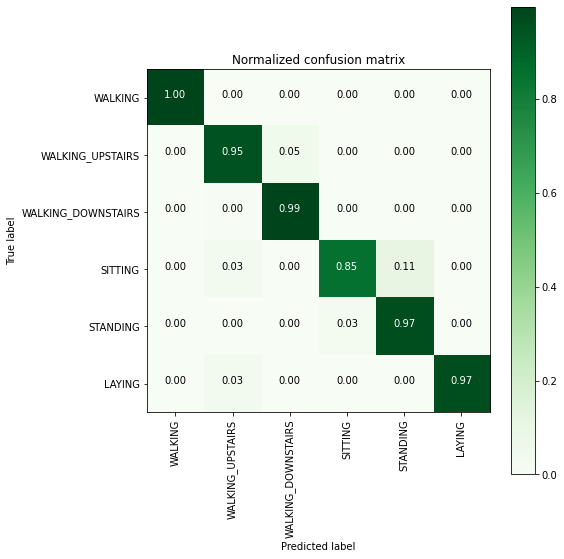

In [96]:
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

# The training accuracy is 98.68%
# The test accuracy is 95.28%